# Notebook to classify the dataset of the NOISELESS images
# Distinction between galaxies with lbt > and < 3Gyrs 
# **On-going work, not finished!**

In [1]:
!nvidia-smi

Thu Dec  9 18:09:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   43C    P0    44W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import mad_std
import tensorflow.keras as tfk
#from sfh.datasets.mergers import tng100_images_noiseless

In [4]:
train_dset,valid_dset,test_dset = tfds.load('tng100_images_noiseless', split=['train[:75%]','train[75%:85%]','train[85%:]'])

2021-12-09 18:09:52.700665: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-09 18:09:53.407706: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


In [ ]:
print(train_dset,test_dset)

In [5]:
print("Test",len(test_dset))
print("Train",len(train_dset))
print("Train",len(valid_dset))
print("Total",len(train_dset)+len(test_dset)+len(valid_dset))

Test 1749
Train 8744
Train 1166
Total 11659


In [ ]:
for example in train_dset.take(2):
    plt.figure()
    plt.imshow(example["image"][:,:,1],cmap='gray')
    lbt=float(example["last_major_merger"])
    plt.title("Last major merger "+str("{:.1f}".format(lbt))+" Gyr ago"+"\n Galaxy ID "+str(int(example["object_id"])))

**Check the distribution of the lookback times**

In [ ]:
# Let's collect a few examples to check their distributions
lbts=[]
for (batch, entry) in enumerate(train_dset.take(len(train_dset))):
    lbts.append(float(entry['last_major_merger'])/13.6)
lbts=np.array(lbts)

In [ ]:
print("There are",len(lbts),"values in the training set")
plt.hist(lbts,20)
plt.title("Histogram of the normalised lookback time")
plt.ylabel('Number')
plt.xlabel("Normalised lookback time")
print(np.mean(lbts))

**Normalise images**

In [ ]:
# Let's collect a few examples to check their distributions
imgs=[]
for (batch, entry) in enumerate(train_dset.take(100)):
    imgs.append(entry['image'])
imgs=np.array(imgs)

In [ ]:
#Check pixel distribution for a few images
for i,b in enumerate(['g', 'r', 'i', 'z']):
    plt.hist(imgs[:,:,:,i].flatten(),100, label=b)
plt.legend()
plt.yscale("log")
plt.ylabel("Number of pixels")
plt.xlabel("Values")
plt.title("Histogram of the pixel values in the first 300 NOISELESS images")

In [ ]:
# Let's evaluate the noise standard deviation in each band, and apply range 
# compression accordingly
scaling = []
mean=[]
for i,b in enumerate(['g', 'r', 'i', 'z']):
    plt.hist(imgs[:,:,:,i].flatten(),100, label=b,alpha=0.5)#,range=[-100,100]);
    sigma = mad_std(imgs[:,:,:,i].flatten())
    scaling.append(sigma)
    mean.append(np.mean(imgs[:,:,:,i].flatten()))
    plt.axvline(sigma, color='C%d'%i,alpha=0.5)
    plt.axvline(-sigma, color='C%d'%i,alpha=0.5)
plt.legend()
plt.yscale("log")

In [ ]:
# Let's have a look at this distribution if we rescale each band by the standard
# deviation
for i,b in enumerate(['g', 'r', 'i', 'z']):
    plt.hist((imgs[:,:,:,i].flatten()-mean[i])/scaling[i],100, label=b,alpha=0.5)#,range=[-10,20]);
plt.legend()
plt.title("Histogram of the pixel values after rescaling by the standard deviation")


In [ ]:
# a common approach for range compression is to apply arcsinh to suppress the
# high amplitude values
#Test with a compression factor manually adjusted
for i,b in enumerate(['g', 'r', 'i', 'z']):
    plt.hist(1/6*np.arcsinh((imgs[:,:,:,i].flatten()-mean[i])/scaling[i]*6),100,
           label=b, alpha=0.5);
plt.legend()
plt.yscale('log')
plt.title("Histogram of the pixel values after scaling by std and arcsinh")

In [ ]:
#Scaling with max

In [6]:
# Using a mapping function to apply preprocessing to our data
def evaluate_scaling(train_dset):
    """
    Evaluates the standard deviation of the pixel values in each band g,r,i,z.
    Input: train_dset (tensforflow dataset): training datset on which we want to evaluate the scaling
    Output: scaling (np array): array containig the std in each band
            mean (np array): array containig the mean in each band
    """
    #Takes 100 images from wich the std will be estimated  
    imgs=[]
    for (batch, entry) in enumerate(train_dset.take(100)):
        imgs.append(entry['image'])
    imgs=np.array(imgs)
    #Computes the scaling
    mean=[]
    scaling = []
    maximum=[]
    for i,b in enumerate(['g', 'r', 'i', 'z']):
        sigma = mad_std(imgs[:,:,:,i].flatten())
        mean.append(np.mean(imgs[:,:,:,i].flatten()))
        scaling.append(sigma)
        maximum.append(np.max(imgs[:,:,:,i].flatten()))
    return scaling,mean,maximum

def preprocessing_classification(example):
    """
    Normalises the images from the original dataset, by dividing it by the std in each band and by appling arcsinh scaling.
    NB: scaling and mean are global variablse, as this notebook is made only for one particular example and cannot be generalized without changing the code
    NB: a compression factor for the arcsinh has been added to compress the values close to 0-1
    Input: example (dict): example from the tensorflow dataset
    Output: norm_img (np ndarray): normalised image
            example["last_major_merger"]: tf tensor containing the lookback time of the last major merger
            example["object_id"]: tf tensor containing the galaxy id        
    """
    img=example["image"]
    ##norm_img=1/6*tf.math.asinh((img-mean)/tf.constant(scaling)*6)
    #Works better with maximum
    norm_img=1/6*tf.math.asinh((img)/tf.constant(maximum)*6)

    #Classes are [recent_merger, older_merger]
    classification=tf.cond(example["last_major_merger"]<3, lambda:[1,0],lambda:[0,1])    
    return norm_img,classification

In [7]:
scaling,mean,maximum=evaluate_scaling(train_dset)
print(scaling,mean,maximum)

2021-12-09 18:10:05.990393: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


[0.013293113401059552, 0.024231357420802166, 0.020571552039110794, 0.004017575382304042] [0.26849395, 0.50093114, 0.44640252, 0.09331725] [279.11002, 606.5274, 571.3022, 133.87555]


In [22]:
#Normalise the training dataset
norm_train_dset = train_dset.map(preprocessing_classification)

classes tf.Tensor([0 1], shape=(2,), dtype=int32)
classes tf.Tensor([0 1], shape=(2,), dtype=int32)


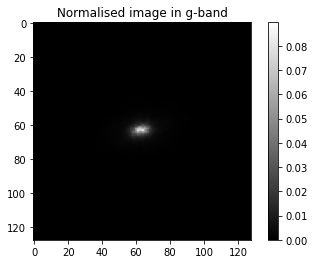

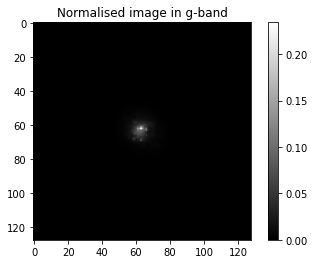

In [24]:
#Check the normalisation on a few examples
norm_imgs,classes=[],[]
for example in norm_train_dset.take(2):
    plt.figure()
    norm_imgs.append(example[0])
    print("classes",example[1])
    plt.imshow(norm_imgs[-1][:,:,0],cmap='gray')
    plt.title("Normalised image in g-band")
    plt.colorbar()

In [ ]:
norm_imgs=[]
for example in norm_train_dset.take(500):
    norm_imgs.append(example[0])
norm_imgs=np.array(norm_imgs)
print(np.shape(norm_imgs),type(norm_imgs))

for i,b in enumerate(['g', 'r', 'i', 'z']):
    plt.hist(norm_imgs[:,:,:,i].flatten(),100,label=b, alpha=0.5);
    
plt.legend()
plt.yscale('log')
plt.title("Histogram of the pixel values after preprocessing")

**Create the input pipeline**

In [25]:
def input_pipeline(mode='train', batch_size=64):
    """
    Creates the input pipeline that loads the dataset and normalises the data
    Possible modes: 'train', 'valid' or 'test'.
    Input: mode (str): specifies the mode for train, validation or test
           batch_size (int): size of the batch
    Output= dataset (tf dataset): properly processes dataset
    """
    if mode == 'train':
        dataset = tfds.load('tng100_images_noiseless', split='train[:80%]')
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
    elif mode=='valid':
        dataset = tfds.load('tng100_images_noiseless', split='train[80%:90%]')
    elif mode=='test':
        dataset = tfds.load('tng100_images_noiseless', split='train[90%:]')
    
    dataset = dataset.map(preprocessing_classification) # Apply data preprocessing
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(-1) # fetch next batches while training current one (-1 for autotune)
    return dataset

In [26]:
#input_train_dset=input_pipeline(mode='train', batch_size=64)

In [47]:
#for ex in input_train_dset.take(1):
#    print(ex[0])

**INPUT DATASETS**

In [28]:
#Input dataset
dataset_training=input_pipeline(mode='train', batch_size=64)
dataset_validation=input_pipeline(mode='valid', batch_size=64)
dataset_test=input_pipeline(mode='test', batch_size=64)

class tf.Tensor([0 1], shape=(2,), dtype=int32)


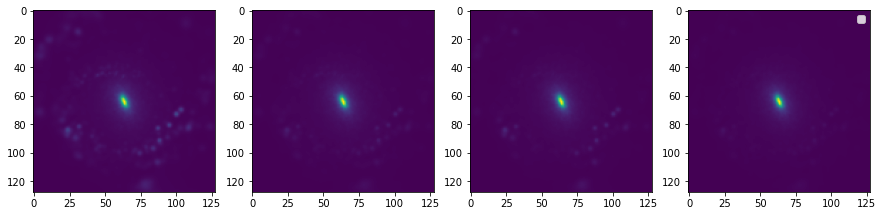

In [50]:
#Displays a few examples
for example in dataset_training.take(1):
    plt.figure(figsize=(15,5))
    plt.subplot(1,4,1)
    plt.imshow(example[0][1,:,:,0],label='g')
    plt.subplot(1,4,2)
    plt.imshow(example[0][1,:,:,1],label='r')
    plt.subplot(1,4,3)
    plt.imshow(example[0][1,:,:,2])
    plt.subplot(1,4,4)
    plt.imshow(example[0][1,:,:,3])
    plt.legend()  
    print("class",example[1][1])

**Define a first simple non-probabilistic CNN**

In [39]:
def build_model_non_probabilistic():
    """
    Creates a CNN that takes as input an image of a galaxy and predicts the corresponding lookback time
    """
    #Define the model
    model = tfk.models.Sequential()
    #1st layer
    model.add(tfk.layers.Conv2D(32, kernel_size=5, padding='same',input_shape=(128,128,4), activation='elu', strides=2))
    model.add(tfk.layers.BatchNormalization())
    #2nd layer
    model.add(tfk.layers.Conv2D(64, kernel_size=5, padding='same', activation='relu', strides=2))
    model.add(tfk.layers.BatchNormalization())
    #Flatten layer
    model.add(tfk.layers.Flatten())
    #Dense
    model.add(tfk.layers.Dense(256,activation='relu'))
    #model.add(tfk.layers.Dropout(0.3))
    model.add(tfk.layers.Dense(128,activation='relu'))
    #Predict a single value, no activation function
    model.add(tfk.layers.Dense(2,activation='relu'))# 2 classes
        
    #Compile for a single value
    model.compile(optimizer=tfk.optimizers.Adam(1e-3), # learning rate will be set by LearningRateScheduler
                loss=tfk.metrics.binary_crossentropy,
                 metrics=["acc"])

    return model

In [40]:
model=build_model_non_probabilistic()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        3232      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
flatten_3 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               16777472  
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

In [41]:
#Train the non probabilistic model
history=model.fit(dataset_training,
          validation_data=dataset_validation,
          steps_per_epoch=10000//64,
          epochs=10)

Epoch 1/10
156/156 [==============================] - 4s 16ms/step - loss: 1.2763 - acc: 0.9163 - val_loss: 1.3180 - val_acc: 0.9141
Epoch 2/10
156/156 [==============================] - 2s 15ms/step - loss: 1.2520 - acc: 0.9184 - val_loss: 1.3180 - val_acc: 0.9141
Epoch 3/10
156/156 [==============================] - 2s 15ms/step - loss: 1.2066 - acc: 0.9213 - val_loss: 1.3180 - val_acc: 0.9141
Epoch 4/10
156/156 [==============================] - 2s 15ms/step - loss: 1.2473 - acc: 0.9187 - val_loss: 1.3133 - val_acc: 0.9141
Epoch 5/10
156/156 [==============================] - 2s 15ms/step - loss: 1.2542 - acc: 0.9183 - val_loss: 1.3113 - val_acc: 0.9141
Epoch 6/10
156/156 [==============================] - 2s 15ms/step - loss: 1.2689 - acc: 0.9175 - val_loss: 1.3113 - val_acc: 0.9141
Epoch 7/10
156/156 [==============================] - 2s 15ms/step - loss: 1.2566 - acc: 0.9180 - val_loss: 1.3113 - val_acc: 0.9141
Epoch 8/10
156/156 [==============================] - 2s 15ms/step - 

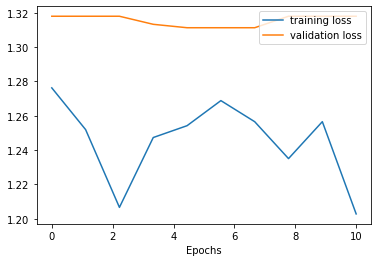

In [42]:
#Plot loss functions
loss=history.history["loss"]
val_loss=history.history["val_loss"]

epochs=np.linspace(0,10,len(loss))
plt.plot(epochs,loss,label='training loss')
plt.plot(epochs,val_loss,label='validation loss')
plt.xlabel("Epochs")
plt.legend(loc='upper right')

Predictions

In [43]:
predictions = model.predict(dataset_test)

In [44]:
# Retrieving last_major_merger for testing set
BATCH_SIZE=64
ground_truth = []
#The order is the same in 'prediction' and when I take examples because there is no shuffle when loading the test dataset
for im,lbt in dataset_test.take(len(dataset_test)):
    ground_truth.append(lbt)
ground_truth = np.concatenate(ground_truth, axis=0)

Text(0.5, 1.0, 'For a simple non-probabilistic CNN')

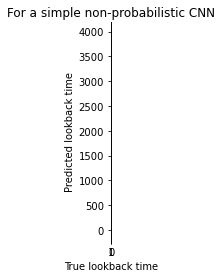

In [45]:
plt.plot(ground_truth, predictions,'.')
plt.xlabel("True lookback time")
plt.ylabel("Predicted lookback time")
plt.plot([0,1],[0,1],color='r')
plt.gca().set_aspect("equal")
plt.title("For a simple non-probabilistic CNN")

ValueError: too many values to unpack (expected 2)

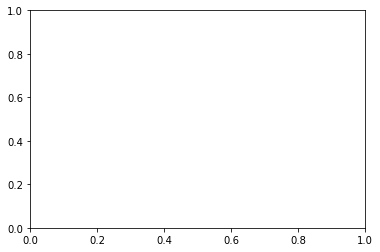

In [46]:
plt.hist2d(ground_truth, predictions.squeeze(), 64, cmap='gist_stern'); 
plt.gca().set_aspect('equal');
plt.plot([0,1],[0,1],color='r')
plt.xlabel('True lookback time')
plt.ylabel('Predicted lookback time');
plt.colorbar()
plt.title("2D-histogram for a simple non-probabilistic CNN")

# ! NOT DONE YET !

**Define a PROBABILISTIC network**

In [ ]:
import tensorflow_probability as tfp
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

def build_model_probabilistic():
    """
    Creates a probabilistic CNN that takes as input an image of a galaxy and predicts the distribution of the corresponding lookback time
    """
    # Number of components in the Gaussian Mixture
    num_components = 2
    # Shape of the distribution
    event_shape = [1]
    # Utility function to compute how many parameters this distribution requires
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)

    #Loss function
    negloglik = lambda x, rv_x: -rv_x.log_prob(x)

    #Define the model
    model = tfk.models.Sequential()
    #1st layer
    model.add(tfk.layers.Conv2D(32, kernel_size=5, padding='same',input_shape=(128,128,4), activation='elu', strides=2))
    model.add(tfk.layers.BatchNormalization())
    #2nd layer
    model.add(tfk.layers.Conv2D(64, kernel_size=5, padding='same', activation='relu', strides=2))
    model.add(tfk.layers.BatchNormalization())
    #Flatten layer
    model.add(tfk.layers.Flatten())
    #Dense
    #model.add(tfk.layers.Dense(512,activation='relu'))
    model.add(tfk.layers.Dense(256,activation='relu'))
    #model.add(tfk.layers.Dropout(0.3))
    model.add(tfk.layers.Dense(128,activation='relu'))
    #Predict a distribution
    model.add(tfkl.Dense(params_size))
    model.add(tfp.layers.MixtureNormal(num_components, event_shape))
    
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
            loss=negloglik)

    return model

In [ ]:
model_probabilistic=build_model_probabilistic()
model_probabilistic.summary()

In [ ]:
"""#Input dataset
dataset_training=input_pipeline(mode='train', batch_size=64)
dataset_validation=input_pipeline(mode='valid', batch_size=64)
dataset_test=input_pipeline(mode='test', batch_size=64)"""

In [ ]:
"""for example in dataset_training.take(2):
    #print(example[1])
    plt.figure(figsize=(15,5))
    plt.subplot(1,4,1)
    plt.imshow(example[0][1,:,:,0],label='g')
    plt.subplot(1,4,2)
    plt.imshow(example[0][1,:,:,1],label='r')
    plt.subplot(1,4,3)
    plt.imshow(example[0][1,:,:,2])
    plt.subplot(1,4,4)
    plt.imshow(example[0][1,:,:,3])
    plt.legend()  
    print("normalised lbt",float(example[1][1]))"""

In [ ]:
#Train the probabilistic model
history_probabilistic=model_probabilistic.fit(dataset_training,
          validation_data=dataset_validation,
          steps_per_epoch=10000//64,
          epochs=10)

In [ ]:
loss=history_probabilistic.history["loss"]
val_loss=history_probabilistic.history["val_loss"]

epochs=np.linspace(0,10,len(loss))
plt.plot(epochs,loss,label='training loss')
plt.plot(epochs,val_loss,label='validation loss')
plt.xlabel("Epochs")
plt.legend(loc='upper right')

In [ ]:
#predictions = model.predict(dataset_test)
for example in dataset_test.take(1):
    true=example[1]
    predictions = model_probabilistic(example[0])

In [ ]:
predictions
to_plot=predictions.sample(1000)
#plt.hist(to_plot[:,:,0])
plt.hist(to_plot[:,0,0].numpy().flatten(),20,alpha=0.5)
plt.hist(to_plot[:,1,0].numpy().flatten(),20,alpha=0.5)
plt.hist(to_plot[:,2,0].numpy().flatten(),20,alpha=0.5)

In [ ]:
print(predictions)

In [ ]:
#Scatter plot for one galaxy
mean=predictions.mean()
std = predictions.stddev()
plt.scatter(mean.numpy(),true)
plt.title("Evolution of the predicted lookback time as a function of the true one")
plt.xlabel("True lookback time")
plt.ylabel("Mean of the predicted lookback time")
plt.gca().set_aspect("equal")
plt.plot([0,1],[0,1],'r')

In [ ]:
#Plot the mean of the probability distribution for each galaxy vs true lbt, with associated stddev
plt.figure(figsize=(10,10))
for example in dataset_test.take(len(dataset_test)):
    true_lbt=example[1]
    predictions = model_probabilistic(example[0])
    mean=(predictions.mean()).numpy().squeeze()
    std = (predictions.stddev()).numpy().squeeze()
    plt.errorbar(true_lbt,mean,yerr=std,fmt='.',color='orange')

plt.plot([0,1],[0,1],'r')
plt.title("Evolution of the predicted lookback time as a function of the true one")
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("True lookback time")
plt.ylabel("Mean of the predicted lookback time")